In [326]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import expon
from scipy.stats import uniform
from scipy.optimize import root
from scipy.optimize import minimize

In [325]:
# "IMPLICIT" SEARCH FUNCTION
###########################################################################

def uij(ki,gammai,Vj,t,kj):
    """Utility patient i receives from doctor j"""

    return Vj * ki - t + np.where(ki >= kj, gammai, 0)
        
def aij(u,λ):
    """Intermediate function to calculate sij"""

    return np.where(u > 0, np.exp(λ*u), 0)
                
def logit_search(ki,gammai,Vj,t,kj,λ):    
    """Probability that patient i visits doctor j"""
    #It takes the J-sized vectors of all doctors' Vj and κj as arguments

    u = uij(ki,gammai,Vj,t,kj)
    ai_total = np.sum(aij(u,λ), axis = 0)

    with np.errstate(divide='ignore', invalid='ignore'):
        # To avoid pesky division by zero warning      
        return np.where(ai_total != 0, aij(u,λ)/ai_total, 0)


# Some auxiliary functions to set up chain rule derivatives

def dlogit_search_dk(ki,gammai,Vj,t,kj,λ):
    """Derivative d sij / d k"""

    u = uij(ki,gammai,Vj,t,kj)
    ai_total = np.sum(aij(u,λ), axis = 0)
    result = np.divide(
        Vj * aij(u,λ) * np.sum(aij(u,λ))- aij(u,λ) * np.sum(Vj * aij(u,λ)),
        (np.sum(aij(u,λ)))**2
        )
    
    return np.where(ai_total != 0, result, 0)


The function 'sij' gives us each patient's Si vector of strategies, and if broadcast correctly it can output all patients' strategies in a single array (given numerable patients in a MC simulation), where each column is each patient’s Si, each row could be added up to a doctor's Qi.

We keep it as a callable function for cases where we want the sij of a particular set of patient x doctor parameters, namely when calculating the derivative of our FOC.

In [915]:
class SearchEq:
    
    def __init__(self,  I,  # Number of patients in the whole market
                        F,  # Distribution of κi
                        G,  # Distribution of γi
                        t,  # Cost of visit
                        λ,  # Logit parameter
                        R,  # Revenue function Rj
                        P,  # Punishment function Pj
                        V,  # Given vector of Vj
                        sij): # Search function
       
        self.I, self.F, self.G, self.t, self.λ, self.R, self.P, self.V, self.sij = I, F, G, t, λ, R, P, V, sij     # Save parameters
    
    def Si(self, k0, s=123):
        """MC simulation of the set of patient strategies out of a given set κ0 of doctor thresholds, seed s"""

        I, F, G, t, λ, V, sij = self.I, self.F, self.G, self.t, self.λ, self.V, self.sij    # Unpack parameters
        
        rng = np.random.RandomState(s)
        ki = F.rvs(size=I, random_state=rng).reshape((1,-1))    # Sample of patients out of distribution
        gammai = G.rvs(size=I, random_state=rng).reshape((1,-1))
        
        Vj = V.reshape((-1,1))      # Reshaping doctor parameters for proper broadcasting
        kj = k0.reshape((-1,1))

        return sij(ki,gammai,Vj,t,kj,λ)

    def Qi(self, k0, s=123):
        """Vector of expected patient demand by each doctor j out of an MC simulation of Si"""

        S = self.Si(k0, s)

        return np.sum(S, axis = 1)
    
    def Xi(self, k0, s=123):
        """Vector of expected certificates granted by each doctor j out of an MC simulation of Si"""

        S = self.Si(k0, s)
        F, I = self.F, self.I
        rng = np.random.RandomState(s)
        ki = F.rvs(size=I, random_state=rng).reshape((1,-1))
        # We recreate the ki vector with the same seed, so it's the same
        
        ki_greater = np.array(ki.reshape((1,-1)) >= k0.reshape((-1,1))).astype(int) 

        return np.sum(S*ki_greater, axis = 1)
    
    def aux_func(self, func, k0):
        """Vector of int func(k0,gamma) dG(gamma) f(k0)"""

        # We will use this function both for func = sij as well as func = ds_dk

        F, G, t, λ, V = self.F, self.G, self.t, self.λ, self.V    # Unpack parameters

        f = lambda x: F.pdf(x)  # Taking pdfs of our κ and γ distributions
        g = lambda x: G.pdf(x)

        s_gamma = lambda x: np.diagonal(func(k0.reshape(1,-1),x,V,t,k0,λ)) 
        # Evaluate sij at each doctor's κj, then take the diagonal, taking doctor j's sij for his own kj
        # This is a lambda function for a given value of γ

        gamma_integrand = lambda x: s_gamma(x) * g(x) # sij(γ) g(γ)

        n = 101
        x = np.linspace(G.ppf(0),G.ppf(1),n) # n-sized linspace across the domain of G

        results = []

        # Loop that evaluates sij(γ) g(γ) for 101 values of γ
        for i in x:
            result = gamma_integrand(i)
            results.append(result)

        results = np.array(results)

        mc_integral = np.sum(results, axis = 0)/n
        # By summing column wise divided by n we get a monte-carlo approximation of an integral

        return - mc_integral * f(k0.reshape(-1,))
    
    def FOC(self, k0, dR, dP, s=123):
        """Out of the previous MC results, it outputs the value of evaluated FOC"""

        Q = self.Qi(k0, s)
        X = self.Xi(k0, s)
        sij = self.sij
        dQ_dk = self.aux_func(sij, k0)

        return (dR(Q) - dP(X))*dQ_dk
    
    def simple_FOC(self, k0, dR, dP, s=123):
        """Out of the previous MC results, it outputs the value of evaluated FOC"""

        I = self.I

        Q = self.Qi(k0, s)
        X = self.Xi(k0, s)

        return (dR(Q) - dP(X))
    
    def dFOC_dk(self, k0, dR, dP, d2R, d2P, ds, df, s=123): #For now, we manually input the derivatives and second derivatives of interest

        Q = self.Qi(k0, s)
        X = self.Xi(k0, s)
        sij = self.sij
        dQ_dk = self.aux_func(sij, k0)
        d2Q_dk = self.aux_func(ds, k0) + self.aux_func(sij, k0) * df(Q) # Double derivative of Q over κ

        return (dR(Q) - dP(X))*d2Q_dk + (d2R(Q) - d2P(X))*dQ_dk
        





In [1015]:
# Number of doctors and patients
I = 10000
J = 50

b = 5

F = expon(scale=1/b)
G = uniform(scale = 1)
H = uniform(scale = 10)

f = lambda x: F.pdf(x)
g = lambda x: G.pdf(x)

rng = np.random.RandomState(seed=123)         # Set up number generator using seed
V = H.rvs(size=J, random_state=rng)     # Create J-size vector of Vj values using H

r = 1.5
p = 1/100

R = lambda x: r * x
P = lambda x: p/2 * x**2

dR = lambda x: r + x - x
dP = lambda x: p * x

d2R = lambda x: 0 + x - x
d2P = lambda x: p + x - x

df = lambda x: -b*f(x)

k0 = np.ones(J)*0.5

λ = 1
t = 0.1

In [1016]:
rng = np.random.RandomState(123)
ki = F.rvs(size=I, random_state=rng).reshape((1,-1))    # Sample of patients out of distribution
gammai = G.rvs(size=I, random_state=rng).reshape((1,-1))

V =  np.sort(V)
Vj = V.reshape((-1,1))      # Reshaping doctor parameters for proper broadcasting
kj = k0.reshape((-1,1))
Vj = np.sort(Vj)

In [104]:
def cartesian_product_stack(k1_vals, k2_vals, J):
    # Create meshgrid for k1_vals and k2_vals
    k1_grid, k2_grid = np.meshgrid(k1_vals, k2_vals, indexing='ij')
    
    # Stack k2_grid J - 1 times along a new axis
    k2_stacked = np.tile(k2_grid[:, :, np.newaxis], (1, 1, J - 1))
    
    # Combine k1_grid and stacked k2_grid along the last axis
    cartesian_grid = np.concatenate((k1_grid[:, :, np.newaxis], k2_stacked), axis=-1)
    
    return cartesian_grid

k1_vals = np.linspace(0,2,100)
k2_vals = np.linspace(0,2,100)

combination = cartesian_product_stack(k1_vals, k2_vals, J)

Qi_combinations = np.apply_along_axis(LogitModel.Qi, axis=-1, arr=combination)
Xi_combinations = np.apply_along_axis(LogitModel.Qi, axis=-1, arr=combination)
FOC_condition = dR(Qi_combinations) - dP(Xi_combinations)
FOC_condition.shape


In [166]:
J = 2
V = H.rvs(size=J, random_state=rng)
LogitModel = SearchEq(I, F, G, t, λ, R, P, V, logit_search)

x = np.linspace(0,2,100)
y = np.linspace(0,2,100)
X, Y = np.meshgrid(x, y)

# Flatten the grids and stack them as 1x2 vectors
XY = np.stack([X.ravel(), Y.ravel()], axis=1)

func2 = lambda x: np.sum(LogitModel.FOC(x, dR, dP))

# Apply the function to each vector
Z = np.apply_along_axis(func2, 1, XY).reshape(X.shape)

# Create the heatmap
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, Z, levels=50, cmap='viridis')
plt.colorbar(label='Function Value')
plt.contour(X, Y, Z, levels=[0], colors='red', linewidths=2)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Heatmap of func([x, y])')
plt.show()

KeyboardInterrupt: 

In [1017]:
LogitModel = SearchEq(I, F, G, t, λ, R, P, Vj, logit_search)
f = lambda x: LogitModel.simple_FOC(x, dR, dP)
Df = lambda x: LogitModel.dFOC_dk(x, dR, dP, d2R, d2P, dlogit_search_dk, df)

In [1038]:
k_guess = np.zeros(J)    
k, error, Dk, beta = NAG(Df, f, k_guess, tol=1e-7, max_iter=100, alpha = 0.01, beta = 0.99)

Convergence not acheived, max iterations


In [1069]:
def compute_hessian(Df, k, h=1e-4):
    hessian = np.zeros((n, n))  # Initialize an n x n matrix for the Hessian

    for i in range(n):
        k_plus_h = np.copy(k)  # Copy the original k
        k_plus_h[i] += h  # Perturb the i-th element of k

        # Compute the second derivative (finite difference approximation)
        second_derivative = (Df(k_plus_h) - Df(k)) / h
        hessian[i, :] = second_derivative
    return hessian

def newton_method(Df, k_0, tol=1e-7, max_iter=100, h=1e-4):

    k = k_0
    for i in range(max_iter):
        gradient = Df(k)  # Evaluate the gradient
        hessian = compute_hessian(Df, k, h=h)  # Evaluate the Hessian matrix
        
        # Check if the Hessian is invertible
        if np.linalg.cond(hessian) > 1e12:
            print("Hessian is nearly singular.")
            break
        
        # Newton's update step
        delta_k = np.linalg.solve(hessian, gradient)  # Equivalent to H^-1 * grad
        k_new = k - delta_k
        
        # Check for convergence
        if np.linalg.norm(delta_k) < tol:
            print(f"Convergence reached in {i+1} iterations.")
            return k_new
        
        k = k_new
        k[k<0] = 0

    print(f"Maximum iterations ({max_iter}) reached without convergence.")
    return k

In [1071]:
k_newton = newton_method(Df, k, tol=1e-7, max_iter=10, h=1e-4)

Hessian is nearly singular.
Maximum iterations (10) reached without convergence.


In [1072]:
f(k_newton)

array([ 0.08592965,  0.03082867, -0.00828313, -0.10436103, -0.11611035,
       -0.1930107 , -0.19537101, -0.23559984, -0.30615324, -0.32142829,
       -0.36223428, -0.37245747, -0.3843971 , -0.43159816, -0.48003863,
       -0.56163982, -0.57632885, -0.02049767, -0.04146855, -0.01625463,
       -0.02061216, -0.2505763 , -0.03695426, -0.02114358, -0.02374466,
       -0.02559759, -0.02791532, -0.02481907, -0.13764299,  1.49349729,
       -0.03538633,  1.49905038, -0.02916782, -0.02529223, -0.02504878,
       -0.03719397, -0.01813942, -0.02556895,  1.49821245,  1.09947455,
        1.49996119, -0.00723399,  1.49653988, -0.00150912,  1.5       ,
        1.5       ,  1.5       ,  1.5       ,  1.5       ,  1.5       ])

In [1059]:
k_plus_h = np.copy(k)  # Copy the original k
k_plus_h[i] += h  # Perturb the i-th element of k

    # Compute the second derivative (finite difference approximation)
second_derivative = Dk(k) 

TypeError: 'numpy.ndarray' object is not callable

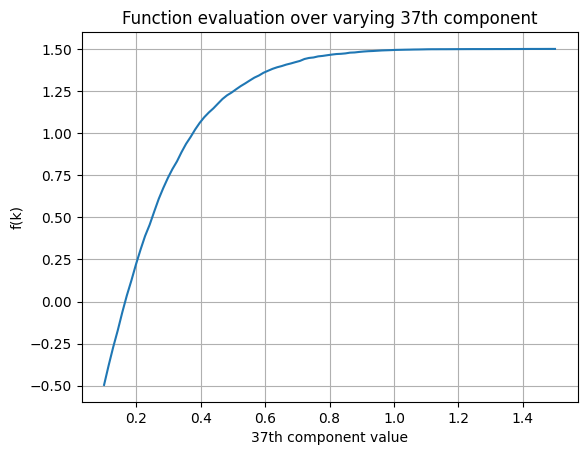

[np.float64(-0.49492657055904954),
 np.float64(-0.3795919571640791),
 np.float64(-0.2709044366983806),
 np.float64(-0.1716615640281265),
 np.float64(-0.06383467128998066),
 np.float64(0.03617366046429682),
 np.float64(0.1252386576918345),
 np.float64(0.2203761613720181),
 np.float64(0.307638548244199),
 np.float64(0.38895094832007615),
 np.float64(0.45543897863188),
 np.float64(0.5334328038881432),
 np.float64(0.6093095639987297),
 np.float64(0.6740322988111316),
 np.float64(0.7333949001108727),
 np.float64(0.7862175862166774),
 np.float64(0.8319207720916049),
 np.float64(0.8866951661766143),
 np.float64(0.9361957915764358),
 np.float64(0.9771183425331891),
 np.float64(1.0216365928169222),
 np.float64(1.0610039532706157),
 np.float64(1.0945110517937182),
 np.float64(1.1225186374798708),
 np.float64(1.1469609278625756),
 np.float64(1.1750168536927426),
 np.float64(1.2026749249757884),
 np.float64(1.2243762958834399),
 np.float64(1.2409317043317438),
 np.float64(1.260422787408315),
 np.f

In [1019]:
def graph_component_37(f, k_original, i, start, stop, num_points=100):
    """
    Function to graph the effect of changing the 37th component of a vector on the output of a function.

    Parameters:
    - f: The function to evaluate.
    - k_original: The original input vector (must be at least 38 elements long).
    - start: The start value for the 37th component.
    - stop: The stop value for the 37th component.
    - num_points: The number of points in the linspace (default is 100).

    Returns:
    - A plot of f(k) as the 37th component of k changes.
    """
    if len(k_original) < i + 1:
        raise ValueError("Input vector must be at least 38 elements long.")
    
    # Generate a linspace for the 37th component
    linspace_values = np.linspace(start, stop, num_points)
    
    # Keep the original vector unchanged for components other than the 37th
    k_fixed = np.copy(k_original)
    
    # Store the results of the function evaluations
    results = []

    # Evaluate the function over the linspace
    for value in linspace_values:
        k_fixed[i] = value  # Update the 37th component (index 36 for 0-based indexing)
        result = f(k_fixed)[i] # Evaluate the function
        results.append(result)

    # Plot the results
    plt.plot(linspace_values, results)
    plt.title("Function evaluation over varying 37th component")
    plt.xlabel("37th component value")
    plt.ylabel("f(k)")
    plt.grid(True)
    plt.show()
    
    return results


graph_component_37(f, k_original, 37, 0.1, 1.5, num_points=100)

In [277]:
def newton(f, Df, x_0, tol=1e-7, max_iter=100_000):     # As seen in QuantEcon
    x = x_0

    # Implement the zero-finding formula
    def q(x):
        Df_x = Df(x)  # Compute Df(x) once to avoid redundant calculations
        return np.where(Df_x == 0, 0, x - f(x) / Df_x)

    error = tol + 1
    n = 0
    while np.any(error > tol):
        n += 1
        if(n > max_iter):
            print("Convergence not acheived, max iterations")
            break
        y = q(x)
        error = np.abs(x - y)
        
        x = y
        x[x<0] = 0
        error = np.where(x == 0, 0, error)
        # Corner solutions at 0 not considered in convergence condition
        if all(x == 0):
            break
    return x, error, Df(x)

In [760]:
def NAG(Df, f, x_0, tol=1e-7, max_iter=100_000, alpha = 0.001, beta = 0.99):
    x = x_0
    v = np.zeros(J)

    # Implement the zero-finding formula
    def q(x, v, alpha, beta):
        arg = x - beta*v
        v_new = beta*v + alpha*Df(arg)
        x_new = x - v_new
        return x_new, v_new

    error = tol + 1
    n = 0
    while np.any(error > tol):
        n += 1
        if(n > max_iter):
            print("Convergence not acheived, max iterations")
            break
        y, v_new = q(x, v, alpha, beta)
        error = np.abs(f(y))
        
        x = y
        v = v_new
        x[x<0] = 0
        error = np.where(x == 0, 0, error)
        # Corner solutions at 0 not considered in convergence condition
        if all(x == 0):
            break
    return x, error, Df(x), beta

In [1027]:
def newNAG(Df, f, x_0, tol=1e-7, max_iter=100_000, alpha = 0.001, beta = 0.99, decay=0.01):
    x = x_0
    v = np.zeros(J)

    # Implement the zero-finding formula
    def q(x, v, alpha, beta):
        arg = x - beta*v
        v_new = beta*v + alpha*Df(arg)
        x_new = x - v_new
        return x_new, v_new

    error = tol + 1
    n = 0
    while np.any(error > tol):
        n += 1
        alpha = alpha / (1 + n*decay)
        beta = beta / (1 + n*decay)
        if(n > max_iter):
            print("Convergence not acheived, max iterations")
            break
        y, v_new = q(x, v, alpha, beta)
        error = np.abs(f(y))
        
        x = y
        v = v_new
        x[x<0] = 0
        error = np.where(x == 0, 0, error)
        # Corner solutions at 0 not considered in convergence condition
        if all(x == 0):
            break
    return x, error, Df(x), beta

In [1]:
def GD(Df, x_0, tol=1e-7, max_iter=100_000, alpha=0.01, beta=0.9):
    """
    Gradient Descent with Momentum and Adaptive Learning Rate Handling.
    """
    x = x_0
    v = np.zeros_like(x)
    
    # Update rule with momentum and adaptive learning rate
    def q(x, v, alpha, beta):
        v_new = beta * v + (1 - beta) * Df(x)
        x_new = x - alpha * v_new
        return x_new, v_new

    error = tol + 1
    n = 0
    
    while np.any(error > tol):
        n += 1
        if n > max_iter:
            print("Convergence not achieved, max iterations reached")
            break

        # Perform the gradient descent update
        y, v_new = q(x, v, alpha, beta)
        
        # Update x and v
        x = y
        v = v_new
        
        # Handle corner solutions (e.g., keeping x non-negative)
        x[x < 0] = 0
        error = np.where(x == 0, 0, error)
        
        if np.all(x == 0):
            break
    
    return x, error, Df(x)

In [190]:
def by_root(k_0,i,f):
    
    def subs(x,k_0,i,f):
        k_0[i] = x[0]
        return f(k_0)[i]
    
    guess = k_0[i]
    function = lambda x: subs(x,k_0,i,f)

    return root(function, guess, method='hybr')

def bisect(f, x_0, tol=1e-3, max_iter=100_000):
    x = x_0
    
    error = tol + 1
    n = 0    
    while np.any(error > tol):
        n += 1
        if(n > max_iter):
            print("Convergence not acheived, max iterations")
            break
        
        results = np.zeros_like(x)
        for i, x_i in enumerate(x):
            if x_i > 0:
                result = np.array(by_root(x, i, f).x)
                results[i] = result[0]  # Update xi with the found root
        x = results

        x[x<0] = 0
        error = np.abs(f(x))
        error = np.where(x == 0, 0, error)
        # Corner solutions at 0 not considered in convergence condition
    return x, error, Df(x)

In [1010]:
LogitModel.Qi(np.zeros(J))

array([ 950.74936584,  995.56606892, 1026.29342594, 1104.40989416,
       1113.83785849, 1175.44309396, 1177.46202758, 1209.9791021 ,
       1264.47107605, 1276.51342616, 1307.12602139, 1315.44753239,
       1325.14420488, 1360.54271197, 1394.78817338, 1453.58126334,
       1465.44384284, 1500.41742818, 1518.19747723, 1524.11302268,
       1525.29579634, 1535.27601281, 1541.60576723, 1552.6272642 ,
       1654.54472033, 1659.78856514, 1687.5212487 , 1709.36298055,
       1757.75827404, 1792.14795673, 1792.99148407, 1851.75342801,
       2053.52318989, 2060.5297897 , 2102.61207088, 2130.08296393,
       2143.72414392, 2364.56450902, 2421.31772405, 2540.14851073,
       2556.37160346, 2567.42334199, 2593.34228367, 2644.46248765,
       3464.33976135, 3626.74322876, 3916.21454302, 4577.87709215,
       5178.81003996, 5267.71220027])

In [210]:
# Function to adaptively reduce learning rate as iterations increase
def adaptive_alpha(alpha, decay_rate, iteration):
    return alpha / (1 + decay_rate * iteration)

# Function to reduce momentum near the solution
def adaptive_beta(beta, error, threshold=0.1):
    if error < threshold:
        return beta * 0.9  # Reduce momentum
    return beta

# Function to clip the gradient to avoid large updates
def gradient_clipping(gradient, clip_value=1.0):
    norm = np.linalg.norm(gradient)
    if norm > clip_value:
        return gradient * (clip_value / norm)
    return gradient

# NAG implementation with adaptive alpha, beta, and gradient clipping
def NAG2(Df, f, x_0, tol=1e-7, max_iter=100_000, alpha=0.01, beta=0.9, decay_rate=0.001, clip_value=1.0, threshold=0.01):
    x = np.array(x_0)  # Ensure x is a NumPy array
    v = np.zeros_like(x)  # Initialize momentum vector
    n = 0
    error = np.inf  # Initialize error to start the loop

    while np.linalg.norm(error) > tol:
        n += 1
        if n > max_iter:
            print("Max iterations reached")
            break

        # Update learning rate and momentum adaptively
        alpha = adaptive_alpha(alpha, decay_rate, n)
        beta = adaptive_beta(beta, np.linalg.norm(f(x)), threshold)

        # Compute the gradient and apply clipping
        gradient = Df(x)
        clipped_gradient = gradient_clipping(gradient, clip_value)


        v_new = beta * v + (1 - beta) * clipped_gradient
        x_new = x - alpha * v_new

        # Compute error
        error = np.abs(f(x_new))
        
        # Update variables for next iteration
        x, v = x_new, v_new

        x[x<0] = 0
        error = np.where(x == 0, 0, error)
        
        # Print intermediate error every 100 iterations
        if n % 100 == 0:
            print(f"Iteration {n}, error: {np.linalg.norm(error)}")

    return x, error, Df(x), beta

In [1029]:
k_guess = np.zeros(J)    
k, error, Dk, beta = NAG(Df, f, k_guess, tol=1e-7, max_iter=1000, alpha = 0.01, beta = 0.99)
k


Convergence not acheived, max iterations


array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.02551845, 0.02705973, 0.0275226 ,
       0.02765293, 0.02870436, 0.02927973, 0.03046342, 0.04051723,
       0.04099094, 0.0437351 , 0.04651853, 0.05171759, 0.05569925,
       0.05573529, 0.06313752, 0.08929772, 0.09009525, 0.09613794,
       0.10004211, 0.10206899, 0.1336918 , 0.14092338, 0.15729605,
       0.15980151, 0.16160153, 0.16538248, 0.17249563, 0.28885378,
       1.95740036, 3.42985216, 5.43754722, 7.00427274, 7.24031166])

In [1037]:
f(k)

array([ 1.15907775e-01,  6.28059965e-02,  2.52377005e-02, -6.64413818e-02,
       -7.76232026e-02, -1.50713660e-01, -1.52943882e-01, -1.91057417e-01,
       -2.57926882e-01, -2.72374572e-01, -3.11067493e-01, -3.20694552e-01,
       -3.31950251e-01, -3.76680606e-01, -4.22656169e-01, -4.99952052e-01,
       -5.13739868e-01, -1.30903978e-03, -1.41004010e-03, -1.22946065e-03,
       -1.32377974e-03, -1.33539750e-03, -1.19275799e-03, -1.42465950e-03,
       -1.25757025e-03, -1.31936235e-03, -1.39507728e-03, -1.31987442e-03,
       -1.24674310e-03, -1.46231115e-03, -1.36834625e-03, -1.21779116e-03,
       -1.35266832e-03, -1.32990576e-03, -1.41693736e-03, -1.28795439e-03,
       -1.15390676e-03, -1.47299367e-03, -1.32028622e-03, -1.30181017e-03,
       -1.22838049e-03, -1.17302427e-03, -1.37610102e-03, -1.46492312e-03,
       -1.51198005e-03,  1.50000000e+00,  1.50000000e+00,  1.50000000e+00,
        1.50000000e+00,  1.50000000e+00])

In [1025]:
bisect(f, k, tol=1e-3, max_iter=1)

Convergence not acheived, max iterations


(array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.02567303,  0.02715764,  0.02766431,
         0.02789611,  0.0288201 ,  0.02943088,  0.03050195,  0.04062462,
         0.04116021,  0.04392777,  0.04671745,  0.0518236 ,  0.05583719,
         0.05588468,  0.06321354,  0.08939889,  0.0902919 ,  0.09628422,
         0.10023126,  0.10221161,  0.13388146,  0.14129402,  0.15750367,
         0.15993559,  0.16177883,  0.16558815,  0.17272593,  0.28910796,
         0.30410758,  5.42110021,  9.42595194, 12.56787015, 13.02195668]),
 array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+

In [342]:
def gradient(Df, x_0, tol=1e-7, max_iter=10000, alpha=0.01):
    x = np.array(x_0)
    n = 0
    error = np.inf

    while np.any(error) > tol and n < max_iter:
        n += 1
        gradient = Df(x)
        x = x - alpha * gradient
        error = np.abs(Df(x))
        x[x<0] = 0
        error = np.where(x == 0, 0, error)

    return x, error, gradient


k_dot, error, Dk = gradient(Df, k, tol=1e-7, max_iter=1000, alpha=0.1)
k_dot

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00378263, 0.00295602, 0.0032324 ,
       0.00472959, 0.00724275, 0.00817818, 0.00847869, 0.01623935,
       0.01811605, 0.01828636, 0.01923438, 0.02018042, 0.0206577 ])

In [378]:
def objective(k):
    FOCs = f(k)
    return np.max(np.abs(FOCs))


bounds = [(0, None) for _ in range(J)]
man = minimize(objective, k, method='TNC', jac = Df, bounds=bounds, tol=1e-3)
a = man.x
a

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.04685613, 0.02742549, 0.04704346,
       0.04074569, 0.02861755, 0.02677616, 0.04029885, 0.05625736,
       0.02999037, 0.02861179, 0.04065334, 0.06000673, 0.03781208])

In [545]:
k = k_original
n=0
i = 3
max_iter = 300

equality = True
while n < max_iter:
    n +=1
    k_new = np.where(f(k) < 0, k + (1/(10**i)), k)
    k_renewed = np.where(f(k_new) > 0, k, k_new)
    k_renewed = np.where(k_original == 0, 0, k_renewed)
    equality = np.array_equal(np.where(f(k)>0),np.where(f(k_renewed)>0))
    if equality:
        k = k_renewed
    else:
        i +=1
# Quiero un loop que a fuerza bruta vaya cicleando por los miembros positivos de k_original
# sumandoles incrementos de 1/10^i tal que f(k) mantenga sus signos, y cuando termine el ciclo
# empieza de nuevo con i + 1 en el primer elemento. Me debería acercar al supremo



array([ 0.29638794,  0.2544035 ,  0.22766318,  0.20878345,  0.20653771,
        0.1922668 ,  0.19180918,  0.18458746,  0.14954899,  0.14702888,
        0.14083118,  0.13914563,  0.13723888,  0.13041385,  0.12409042,
        0.11369947,  0.0834175 ,  0.07752436,  0.07460424,  0.07364185,
        0.07345766,  0.07186141,  0.07085586,  0.06912792,  0.05397909,
        0.05322146,  0.04937475,  0.04642108,  0.03999757,  0.03558305,
        0.03548177,  0.02831214,  0.00603592,  0.00533025,  0.00114984,
       -0.00151368, -0.00281496, -0.09762414, -0.10227298,  0.04328377,
        0.04209203,  0.04128519,  0.03944054,  0.03584003,  0.03607208,
        0.02898883,  0.01752984,  0.03908028,  0.04444831,  0.04235063])

In [596]:
k_change = k[k_original>0]

k = k_original
n=0
i = 3
max_iter = 25
while n < max_iter:
    k_renewed = k
    j = 0
    while j < len(k_change):
        n +=1
        if n > max_iter:
            break
        k_renewed[J - j - 1] += 1/(10**i)
        equality = np.array_equal(np.where(f(k)>0),np.where(f(k_renewed)>0))
        if equality:
            k[J - j - 1] = k_renewed[J - j - 1]
        else:
            j +=1
    i += 1

k - k_original

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [601]:
k_renewed[J - j - 1] += 1/(10**i)
np.any(k_original) == np.any(k_renewed)

np.True_

In [1023]:
def iterative_update(f, k_original, J, max_iter=10, i=3, max=7):
    k = np.array(k_original)
    k_change = k[k_original > 0]  # Elements of k to be updated
    n = 0
    
    equalities = []
    while n < max_iter:
        
        k_renewed = np.copy(k)  # Copy of k to work with in each iteration
        step_size = 1 / (10 ** i)  # Define the step size

        j = 0
        while j < len(k_change):

            n += 1
            if n > max_iter:
                break

            # Adjust the element of k_renewed by the step size
            k_renewed[J - j - 1] += step_size

            # Check if the positive entries in f(k) match after update
            equality = (np.sign(f(k)) == np.sign(f(k_renewed))).all()

            if equality:
                b = 1
                k[J - j - 1] += step_size  # Update the original k
            else:
                b = 0
                k_renewed[J - j - 1] -= step_size
                j += 1  # Move to the next index if no match found
            
            equalities.append(b)

        i += 1  # Increase i for finer steps in the next iteration
        if i > max:
            i = 1


    return k, equalities, j, i

k_new, equalities, j, i = iterative_update(f, k, J, max_iter=10000, i=2)

KeyboardInterrupt: 

In [736]:
f(k_new)

array([ 2.68088913e-01,  2.26114646e-01,  1.99381718e-01,  1.80520830e-01,
        1.78277317e-01,  1.64020419e-01,  1.63563244e-01,  1.56348545e-01,
        1.21321386e-01,  1.18803675e-01,  1.12611865e-01,  1.10927916e-01,
        1.09022965e-01,  1.02204359e-01,  9.58868602e-02,  8.55055749e-02,
        5.52254915e-02,  4.93377060e-02,  4.64202374e-02,  4.54587173e-02,
        4.52746950e-02,  4.36798837e-02,  4.26752371e-02,  4.09488591e-02,
        2.58135817e-02,  2.50566273e-02,  2.12133282e-02,  1.82622741e-02,
        1.18444319e-02,  7.43377944e-03,  7.33259579e-03,  1.69223147e-04,
       -2.20877661e-02, -2.27928354e-02, -2.69696704e-02, -2.96309257e-02,
       -3.09311032e-02, -1.25723971e-01, -1.30369049e-01, -6.24863923e-02,
       -6.36844597e-02, -6.44955777e-02, -6.63500089e-02, -4.65923589e-02,
       -8.97142752e-04, -8.00118494e-03, -1.94935596e-02, -4.13574936e-02,
       -5.73835843e-02, -5.94998195e-02])

In [542]:
k = k_original
n=0
i = 3
max_iter = 30

equality = True
stop_condition = np.zeros(J)
while n < max_iter:
    n +=1
    k_new = np.where(f(k) < 0,
                    k + 1/(10**i),
                    k
                    )
    k_renewed = np.where(f(k_new) > 0,
                        k,
                        k_new)
    stop_condition = np.where((f(k_new) > 0) & (f(k) < 0),
                            1,
                            stop_condition)
    k_renewed = np.where(k_original == 0,
                         0,
                         k_renewed)
    equality = np.array_equal(np.where(f(k)>0),np.where(f(k_renewed)>0))
    if equality:
        k = k_renewed
    else:
        if np.any(stop_condition[k > 0]) == 1:
            i +=1


(array([], dtype=int64),)

In [499]:
k_new = np.where(f(k) < 0, k + ((-1)**n)*(1/(10**i)), k)
k_renewed = np.where(f(k_new) > 0, k, k_new)
k_renewed = np.where(k_original == 0, 0, k_renewed)
k = k_renewed
k

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.01585329,
       0.0161452 , 0.01634267, 0.01658267, 0.01675761, 0.02480734,
       0.02593765, 0.02768175, 0.03114876, 0.03347691, 0.03370601])

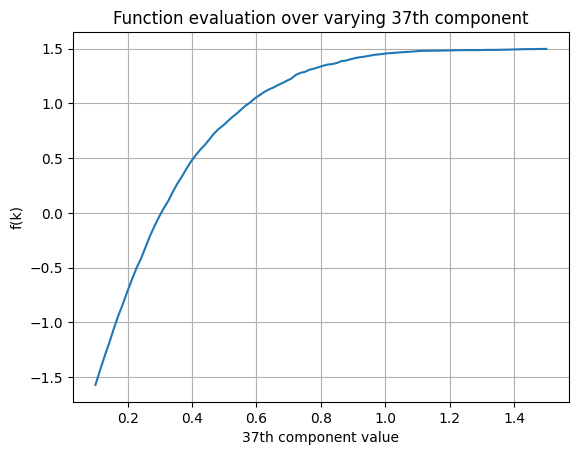

[np.float64(-1.571889929919704),
 np.float64(-1.4392248841590685),
 np.float64(-1.310965831065452),
 np.float64(-1.19175331534883),
 np.float64(-1.0617172227842544),
 np.float64(-0.9414182365281558),
 np.float64(-0.8349246543302931),
 np.float64(-0.7188826927591463),
 np.float64(-0.609469893308876),
 np.float64(-0.5055978148273259),
 np.float64(-0.41838733005443385),
 np.float64(-0.3131353700475126),
 np.float64(-0.20852851858380617),
 np.float64(-0.11780029752877863),
 np.float64(-0.033558866471841586),
 np.float64(0.042068998665926616),
 np.float64(0.11008463916419764),
 np.float64(0.1929473261239425),
 np.float64(0.2686173166596446),
 np.float64(0.33255186886820853),
 np.float64(0.4048661779345706),
 np.float64(0.4696762493226938),
 np.float64(0.5260747109532099),
 np.float64(0.5761917193532261),
 np.float64(0.6193746489983124),
 np.float64(0.670311059304389),
 np.float64(0.7230269957937112),
 np.float64(0.7647127427724475),
 np.float64(0.7967713449853745),
 np.float64(0.83544973694

In [1036]:
def graph_component_37(f, k_original, i, start, stop, num_points=100):
    """
    Function to graph the effect of changing the 37th component of a vector on the output of a function.

    Parameters:
    - f: The function to evaluate.
    - k_original: The original input vector (must be at least 38 elements long).
    - start: The start value for the 37th component.
    - stop: The stop value for the 37th component.
    - num_points: The number of points in the linspace (default is 100).

    Returns:
    - A plot of f(k) as the 37th component of k changes.
    """
    if len(k_original) < i + 1:
        raise ValueError("Input vector must be at least 38 elements long.")
    
    # Generate a linspace for the 37th component
    linspace_values = np.linspace(start, stop, num_points)
    
    # Keep the original vector unchanged for components other than the 37th
    k_fixed = np.copy(k_original)
    
    # Store the results of the function evaluations
    results = []

    # Evaluate the function over the linspace
    for value in linspace_values:
        k_fixed[i] = value  # Update the 37th component (index 36 for 0-based indexing)
        result = f(k_fixed)[i] # Evaluate the function
        results.append(result)

    # Plot the results
    plt.plot(linspace_values, results)
    plt.title("Function evaluation over varying 37th component")
    plt.xlabel("37th component value")
    plt.ylabel("f(k)")
    plt.grid(True)
    plt.show()
    
    return results


graph_component_37(f, k, 45, 0.1, 1.5, num_points=100)